# 音楽ラベリング：マルチ特徴量 + ResNet分類 + Data Augmentation
## 4種類の音響特徴量（Melspectrogram, MFCC, MFCC Delta, MFCC Delta-Delta）を活用
より豊富な音響特徴量を使用してResNetで音楽のジャンル分類を行います。

In [3]:
# 音楽ラベリング：マルチ特徴量 + ResNet分類 + Data Augmentation
# 4種類の音響特徴量を組み合わせてより高精度な分類を実現

import pandas as pd
import numpy as np
import librosa
import librosa.feature
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
import japanize_matplotlib 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     GlobalAveragePooling2D, BatchNormalization, Add, 
                                     Input, Activation, Concatenate)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

print("マルチ特徴量音響分析ライブラリを読み込み完了")
print(f"TensorFlow バージョン: {tf.__version__}")
print(f"Librosa バージョン: {librosa.__version__}")

マルチ特徴量音響分析ライブラリを読み込み完了
TensorFlow バージョン: 2.20.0
Librosa バージョン: 0.11.0


In [4]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("=== 音楽ジャンルラベル ===")
for i, genre in label_list.items():
    print(f"{i}: {genre}")
print(f"\n訓練データ総数: {len(train_master)}")
print(f"各クラスのデータ数: {train_master['label_id'].value_counts().iloc[0]}")

=== 音楽ジャンルラベル ===
0: blues
1: classical
2: country
3: disco
4: hiphop
5: jazz
6: metal
7: pop
8: reggae
9: rock

訓練データ総数: 500
各クラスのデータ数: 50


In [5]:
# 強化されたデータ拡張関数
def add_white_noise(audio, noise_factor=0.005):
    """ホワイトノイズを追加"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """時間軸方向のシフト"""
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    if shift > 0:
        augmented_audio = np.r_[audio[shift:], np.zeros(shift)]
    else:
        augmented_audio = np.r_[np.zeros(-shift), audio[:shift]]
    return augmented_audio

def time_stretch(audio, rate=None):
    """時間ストレッチ（速度変更）"""
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps=None):
    """ピッチシフト（新規追加）"""
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)  # ±2半音
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

print("データ拡張関数を定義完了（ピッチシフト追加）")

データ拡張関数を定義完了（ピッチシフト追加）


In [6]:
# マルチ特徴量抽出関数
def extract_multi_features(audio, sr, n_mfcc=13, n_mels=128, max_len=1225):
    """4種類の音響特徴量を抽出"""
    
    # 1. Melspectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # 3. MFCC Delta (1次微分)
    mfcc_delta = librosa.feature.delta(mfccs)
    
    # 4. MFCC Delta-Delta (2次微分)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # すべての特徴量を同じ時間長に調整
    features = [mel_spec_db, mfccs, mfcc_delta, mfcc_delta2]
    processed_features = []
    
    for feature in features:
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = feature[:, :max_len]
        processed_features.append(feature)
    
    return processed_features

def create_4channel_input(features_list):
    """4つの特徴量を4チャンネル入力に変換"""
    mel_spec, mfcc, mfcc_delta, mfcc_delta2 = features_list
    
    # MFCCを13次元から128次元にリサイズ（Melspectrogramと合わせる）
    mfcc_resized = np.resize(mfcc, (128, mfcc.shape[1]))
    mfcc_delta_resized = np.resize(mfcc_delta, (128, mfcc_delta.shape[1]))
    mfcc_delta2_resized = np.resize(mfcc_delta2, (128, mfcc_delta2.shape[1]))
    
    # 4チャンネルとして結合
    four_channel = np.stack([
        mel_spec,           # Channel 0: Melspectrogram
        mfcc_resized,       # Channel 1: MFCC
        mfcc_delta_resized, # Channel 2: MFCC Delta
        mfcc_delta2_resized # Channel 3: MFCC Delta-Delta
    ], axis=-1)
    
    return four_channel

print("マルチ特徴量抽出関数を定義完了")
print("特徴量構成:")
print("  Channel 0: Melspectrogram (128 x 130)")
print("  Channel 1: MFCC (13->128 x 130)")
print("  Channel 2: MFCC Delta (13->128 x 130)")
print("  Channel 3: MFCC Delta-Delta (13->128 x 130)")

マルチ特徴量抽出関数を定義完了
特徴量構成:
  Channel 0: Melspectrogram (128 x 130)
  Channel 1: MFCC (13->128 x 130)
  Channel 2: MFCC Delta (13->128 x 130)
  Channel 3: MFCC Delta-Delta (13->128 x 130)


=== 4種類の音響特徴量可視化 ===
サンプル音声: train_sound/train_0.au
ジャンル: reggae
音声長: 30.01秒


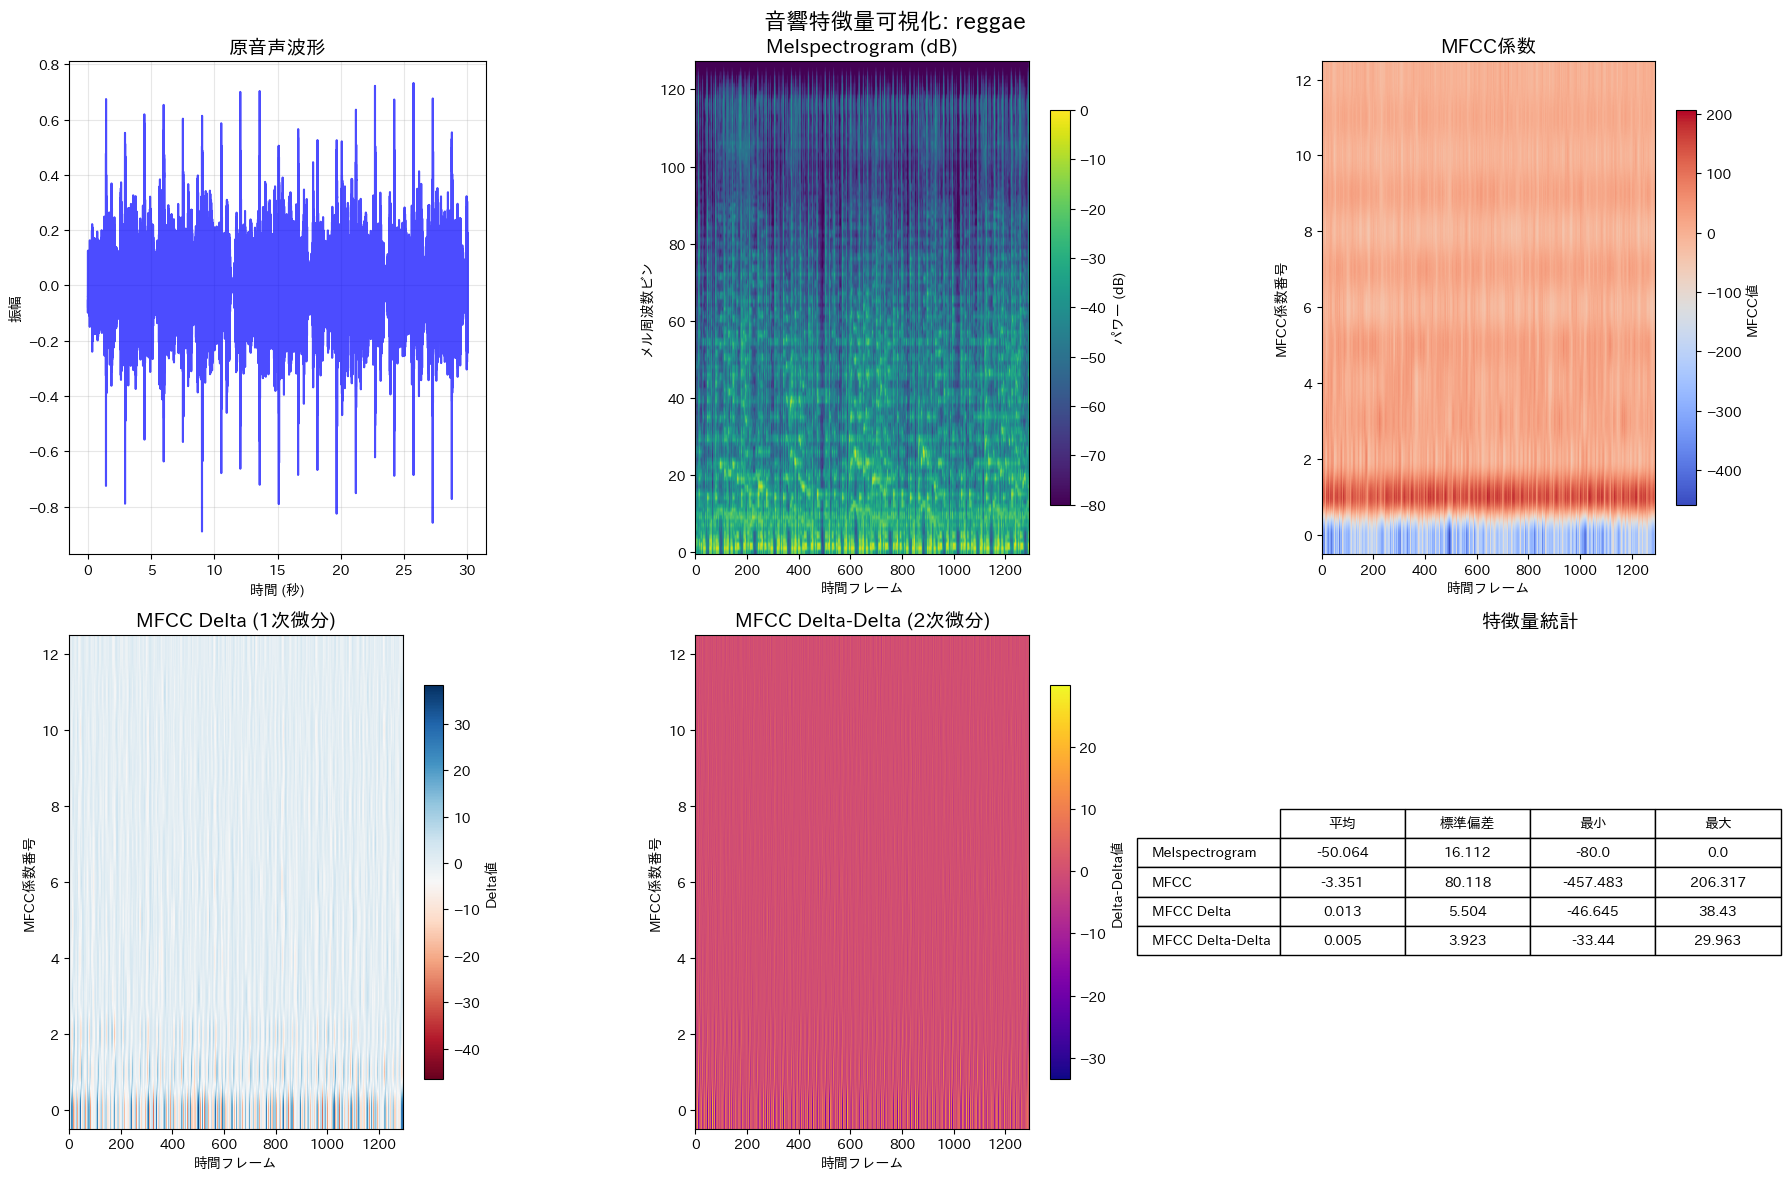


=== 特徴量詳細情報 ===
 Melspectrogram: 形状(128, 1293) | 範囲[-80.000,   0.000] | 平均-50.064 ± 16.112
           MFCC: 形状(13, 1293) | 範囲[-457.483, 206.317] | 平均 -3.351 ± 80.118
     MFCC Delta: 形状(13, 1293) | 範囲[-46.645,  38.430] | 平均  0.013 ±  5.504
MFCC Delta-Delta: 形状(13, 1293) | 範囲[-33.440,  29.963] | 平均  0.005 ±  3.923

=== 特徴量の意味 ===
Melspectrogram  : 周波数成分の時間変化 (音の色彩・質感)
MFCC           : 音声の基本的な特徴量 (音の骨格)
MFCC Delta     : MFCCの時間変化率 (音の動き)
MFCC Delta-Delta: MFCCの加速度的変化 (音の躍動感)


In [7]:
# 特徴量可視化デモ
def visualize_features_demo():
    """4種類の特徴量を実際の音声データで可視化"""
    
    # サンプル音声ファイルを選択
    train_files = natsorted(glob.glob('train_sound*/train_*.au'))
    sample_file = train_files[0]  # 最初のファイルを使用
    
    # 音声データ読み込み
    audio, sr = librosa.load(sample_file)
    file_index = int(sample_file.split('_')[-1].split('.')[0])
    genre_name = label_list[train_master.iloc[file_index]['label_id']]
    
    print(f"サンプル音声: {sample_file}")
    print(f"ジャンル: {genre_name}")
    print(f"音声長: {len(audio)/sr:.2f}秒")
    
    # 特徴量抽出
    n_mels = 128
    n_mfcc = 13
    
    # 1. Melspectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 2. MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # 3. MFCC Delta (1次微分)
    mfcc_delta = librosa.feature.delta(mfccs)
    
    # 4. MFCC Delta-Delta (2次微分)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # 可視化
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'音響特徴量可視化: {genre_name}', fontsize=16, fontweight='bold')
    
    # 元の波形
    time_axis = np.linspace(0, len(audio)/sr, len(audio))
    axes[0, 0].plot(time_axis, audio, color='blue', alpha=0.7)
    axes[0, 0].set_title('原音声波形', fontsize=14)
    axes[0, 0].set_xlabel('時間 (秒)')
    axes[0, 0].set_ylabel('振幅')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Melspectrogram
    im1 = axes[0, 1].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='viridis')
    axes[0, 1].set_title('Melspectrogram (dB)', fontsize=14)
    axes[0, 1].set_xlabel('時間フレーム')
    axes[0, 1].set_ylabel('メル周波数ビン')
    plt.colorbar(im1, ax=axes[0, 1], shrink=0.8, label='パワー (dB)')
    
    # MFCC
    im2 = axes[0, 2].imshow(mfccs, aspect='auto', origin='lower', cmap='coolwarm')
    axes[0, 2].set_title('MFCC係数', fontsize=14)
    axes[0, 2].set_xlabel('時間フレーム')
    axes[0, 2].set_ylabel('MFCC係数番号')
    plt.colorbar(im2, ax=axes[0, 2], shrink=0.8, label='MFCC値')
    
    # MFCC Delta
    im3 = axes[1, 0].imshow(mfcc_delta, aspect='auto', origin='lower', cmap='RdBu')
    axes[1, 0].set_title('MFCC Delta (1次微分)', fontsize=14)
    axes[1, 0].set_xlabel('時間フレーム')
    axes[1, 0].set_ylabel('MFCC係数番号')
    plt.colorbar(im3, ax=axes[1, 0], shrink=0.8, label='Delta値')
    
    # MFCC Delta-Delta
    im4 = axes[1, 1].imshow(mfcc_delta2, aspect='auto', origin='lower', cmap='plasma')
    axes[1, 1].set_title('MFCC Delta-Delta (2次微分)', fontsize=14)
    axes[1, 1].set_xlabel('時間フレーム')
    axes[1, 1].set_ylabel('MFCC係数番号')
    plt.colorbar(im4, ax=axes[1, 1], shrink=0.8, label='Delta-Delta値')
    
    # 特徴量統計
    features = [mel_spec_db, mfccs, mfcc_delta, mfcc_delta2]
    feature_names = ['Melspectrogram', 'MFCC', 'MFCC Delta', 'MFCC Delta-Delta']
    
    stats_data = []
    for feature in features:
        stats_data.append([
            np.mean(feature),
            np.std(feature),
            np.min(feature),
            np.max(feature)
        ])
    
    stats_df = pd.DataFrame(stats_data, 
                           columns=['平均', '標準偏差', '最小', '最大'],
                           index=feature_names)
    
    # 統計表を可視化
    axes[1, 2].axis('tight')
    axes[1, 2].axis('off')
    table = axes[1, 2].table(cellText=np.round(stats_df.values, 3),
                           rowLabels=stats_df.index,
                           colLabels=stats_df.columns,
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1, 2].set_title('特徴量統計', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 特徴量の詳細情報
    print("\n=== 特徴量詳細情報 ===")
    for name, feature in zip(feature_names, features):
        print(f"{name:>15}: 形状{feature.shape} | "
              f"範囲[{np.min(feature):>7.3f}, {np.max(feature):>7.3f}] | "
              f"平均{np.mean(feature):>7.3f} ± {np.std(feature):>6.3f}")
    
    print("\n=== 特徴量の意味 ===")
    print("Melspectrogram  : 周波数成分の時間変化 (音の色彩・質感)")
    print("MFCC           : 音声の基本的な特徴量 (音の骨格)")
    print("MFCC Delta     : MFCCの時間変化率 (音の動き)")
    print("MFCC Delta-Delta: MFCCの加速度的変化 (音の躍動感)")
    
    return features

# 特徴量可視化実行
print("=== 4種類の音響特徴量可視化 ===")
features = visualize_features_demo()

In [8]:
# 拡張されたマルチ特徴量訓練データの作成
train_files = natsorted(glob.glob('train_sound*/train_*.au'))
print(f"元の訓練ファイル数: {len(train_files)}")

X_train_multi = []
y_train_multi = []

print("マルチ特徴量データ拡張処理を開始...")
print("拡張手法: 元データ + ホワイトノイズ + 時間シフト + 時間ストレッチ + ピッチシフト")

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)} ({i/len(train_files)*100:.1f}%)")
    
    try:
        # 元の音声データを読み込み
        y, sr = librosa.load(file_path)
        file_index = int(file_path.split('_')[-1].split('.')[0])
        label = train_master.iloc[file_index]['label_id']
        
        # 各種拡張データと特徴量抽出
        augmentations = [
            ('original', y),
            ('noise', add_white_noise(y)),
            ('shift', time_shift(y)),
            ('stretch', time_stretch(y)),
            ('pitch', pitch_shift(y, sr))
        ]
        
        for aug_name, audio_data in augmentations:
            # マルチ特徴量抽出
            features = extract_multi_features(audio_data, sr)
            four_channel_data = create_4channel_input(features)
            
            X_train_multi.append(four_channel_data)
            y_train_multi.append(label)
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_train = np.array(X_train_multi)
y_train = np.array(y_train_multi)

print(f"\n=== マルチ特徴量データ作成完了 ===")
print(f"拡張後の訓練データ形状: {X_train.shape}")
print(f"拡張後のラベル形状: {y_train.shape}")
print(f"データ拡張率: {len(y_train_multi) / len(train_files):.1f}倍")
print(f"チャンネル数: {X_train.shape[-1]} (Mel + MFCC + Delta + Delta-Delta)")
print(f"特徴量解像度: {X_train.shape[1]} x {X_train.shape[2]}")

元の訓練ファイル数: 500
マルチ特徴量データ拡張処理を開始...
拡張手法: 元データ + ホワイトノイズ + 時間シフト + 時間ストレッチ + ピッチシフト
処理中: 0/500 (0.0%)
処理中: 50/500 (10.0%)
処理中: 100/500 (20.0%)
処理中: 150/500 (30.0%)
処理中: 200/500 (40.0%)
処理中: 250/500 (50.0%)
処理中: 300/500 (60.0%)
処理中: 350/500 (70.0%)
処理中: 400/500 (80.0%)
処理中: 450/500 (90.0%)

=== マルチ特徴量データ作成完了 ===
拡張後の訓練データ形状: (2500, 128, 1225, 4)
拡張後のラベル形状: (2500,)
データ拡張率: 5.0倍
チャンネル数: 4 (Mel + MFCC + Delta + Delta-Delta)
特徴量解像度: 128 x 1225


In [9]:
# テストデータのマルチ特徴量処理
test_files = natsorted(glob.glob('test_sound*/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test_multi = []

print("テストデータのマルチ特徴量抽出中...")
for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)} ({i/len(test_files)*100:.1f}%)")
    
    try:
        y, sr = librosa.load(file_path)
        features = extract_multi_features(y, sr)
        four_channel_data = create_4channel_input(features)
        X_test_multi.append(four_channel_data)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

X_test = np.array(X_test_multi)
print(f"\nテストデータ形状: {X_test.shape}")

テストファイル数: 500
テストデータのマルチ特徴量抽出中...
処理中: 0/500 (0.0%)
処理中: 50/500 (10.0%)
処理中: 100/500 (20.0%)
処理中: 150/500 (30.0%)
処理中: 200/500 (40.0%)
処理中: 250/500 (50.0%)
処理中: 300/500 (60.0%)
処理中: 350/500 (70.0%)
処理中: 400/500 (80.0%)
処理中: 450/500 (90.0%)

テストデータ形状: (500, 128, 1225, 4)


In [11]:
# データの前処理（4チャンネル対応）
print("マルチ特徴量データの前処理中...")

# データ正規化（チャンネルごとに正規化）
for channel in range(4):
    channel_data = X_train[:, :, :, channel]
    mean_val = np.mean(channel_data)
    std_val = np.std(channel_data)
    
    X_train[:, :, :, channel] = (X_train[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    X_test[:, :, :, channel] = (X_test[:, :, :, channel] - mean_val) / (std_val + 1e-8)
    
    print(f"Channel {channel} 正規化完了 (mean: {mean_val:.3f}, std: {std_val:.3f})")

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 訓練データを訓練用と検証用に分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n=== データ分割結果 ===")
print(f"訓練データ形状: {X_train_split.shape}")
print(f"検証データ形状: {X_val_split.shape}")
print(f"テストデータ形状: {X_test.shape}")
print(f"チャンネル構成: [Mel, MFCC, Delta, Delta-Delta]")
print(f"データ範囲: [{np.min(X_train_split):.3f}, {np.max(X_train_split):.3f}]")

マルチ特徴量データの前処理中...
Channel 0 正規化完了 (mean: -43.148, std: 15.667)
Channel 1 正規化完了 (mean: -1.907, std: 65.968)
Channel 2 正規化完了 (mean: 0.002, std: 3.326)
Channel 3 正規化完了 (mean: 0.000, std: 2.024)

=== データ分割結果 ===
訓練データ形状: (2000, 128, 1225, 4)
検証データ形状: (500, 128, 1225, 4)
テストデータ形状: (500, 128, 1225, 4)
チャンネル構成: [Mel, MFCC, Delta, Delta-Delta]
データ範囲: [-27.968, 28.943]


In [12]:
# マルチ特徴量対応ResNetアーキテクチャ
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    """改良された残差ブロック"""
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x if stride == 1 else MaxPooling2D(stride, stride, padding='same')(x)
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_multi_feature_resnet(input_shape=(128, 130, 4), num_classes=10):
    """4チャンネル対応ResNet"""
    inputs = Input(shape=input_shape)
    
    # Initial convolution (4チャンネルに対応)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # ResNet blocks
    # Stage 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Stage 2
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)
    
    # Stage 3
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)
    
    # Stage 4
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# マルチ特徴量ResNetモデルの作成
print("マルチ特徴量ResNetモデル構築中...")
multi_resnet_model = build_multi_feature_resnet(input_shape=(128, 130, 4), num_classes=10)

# モデルのコンパイル
optimizer = Adam(learning_rate=0.001, weight_decay=1e-4)
multi_resnet_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# モデルの構造を表示
multi_resnet_model.summary()
print(f"\n総パラメータ数: {multi_resnet_model.count_params():,}")
print("4チャンネル対応マルチ特徴量ResNet構築完了")

マルチ特徴量ResNetモデル構築中...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 130,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 65,    │     12,608 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 65,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 65,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 33,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 33,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 33,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 33,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 33,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 33,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 33,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 33,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 33,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 33,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 33,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 33,    │        256 │ conv2d_4[0][0]  

 Total params: 11,622,218 (44.34 MB)

 Trainable params: 11,612,618 (44.30 MB)

 Non-trainable params: 9,600 (37.50 KB)


総パラメータ数: 11,622,218
4チャンネル対応マルチ特徴量ResNet構築完了


In [13]:
# 高度な学習スケジューリングでの訓練
print("=== マルチ特徴量ResNet訓練開始 ===")

# コールバック設定
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_multi_feature_resnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# カスタム学習率スケジューラ
def custom_lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr * (epoch + 1) / 10  # Warmup
    elif epoch < 50:
        return 0.001 * (0.95 ** (epoch - 10))  # Exponential decay
    else:
        return 0.001 * 0.5 * (1 + np.cos(np.pi * (epoch - 50) / 50))  # Cosine decay

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(custom_lr_scheduler, verbose=1)

print(f"訓練設定:")
print(f"  訓練データ: {len(X_train_split):,} サンプル")
print(f"  検証データ: {len(X_val_split):,} サンプル")
print(f"  バッチサイズ: 32")
print(f"  最大エポック数: 100")
print(f"  特徴量: 4チャンネル (Mel + MFCC + Delta + Delta-Delta)")

# モデルの訓練
history = multi_resnet_model.fit(
    X_train_split, y_train_split,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler],
    verbose=1
)

print(f"\n=== 訓練完了 ===")
print(f"実行エポック数: {len(history.history['loss'])}")

# 最終性能評価
final_val_loss, final_val_accuracy, final_val_top5 = multi_resnet_model.evaluate(
    X_val_split, y_val_split, verbose=0
)
print(f"最終検証精度: {final_val_accuracy:.4f}")
print(f"最終Top-5精度: {final_val_top5:.4f}")
print(f"最終検証損失: {final_val_loss:.4f}")

=== マルチ特徴量ResNet訓練開始 ===
訓練設定:
  訓練データ: 2,000 サンプル
  検証データ: 500 サンプル
  バッチサイズ: 32
  最大エポック数: 100
  特徴量: 4チャンネル (Mel + MFCC + Delta + Delta-Delta)


: 

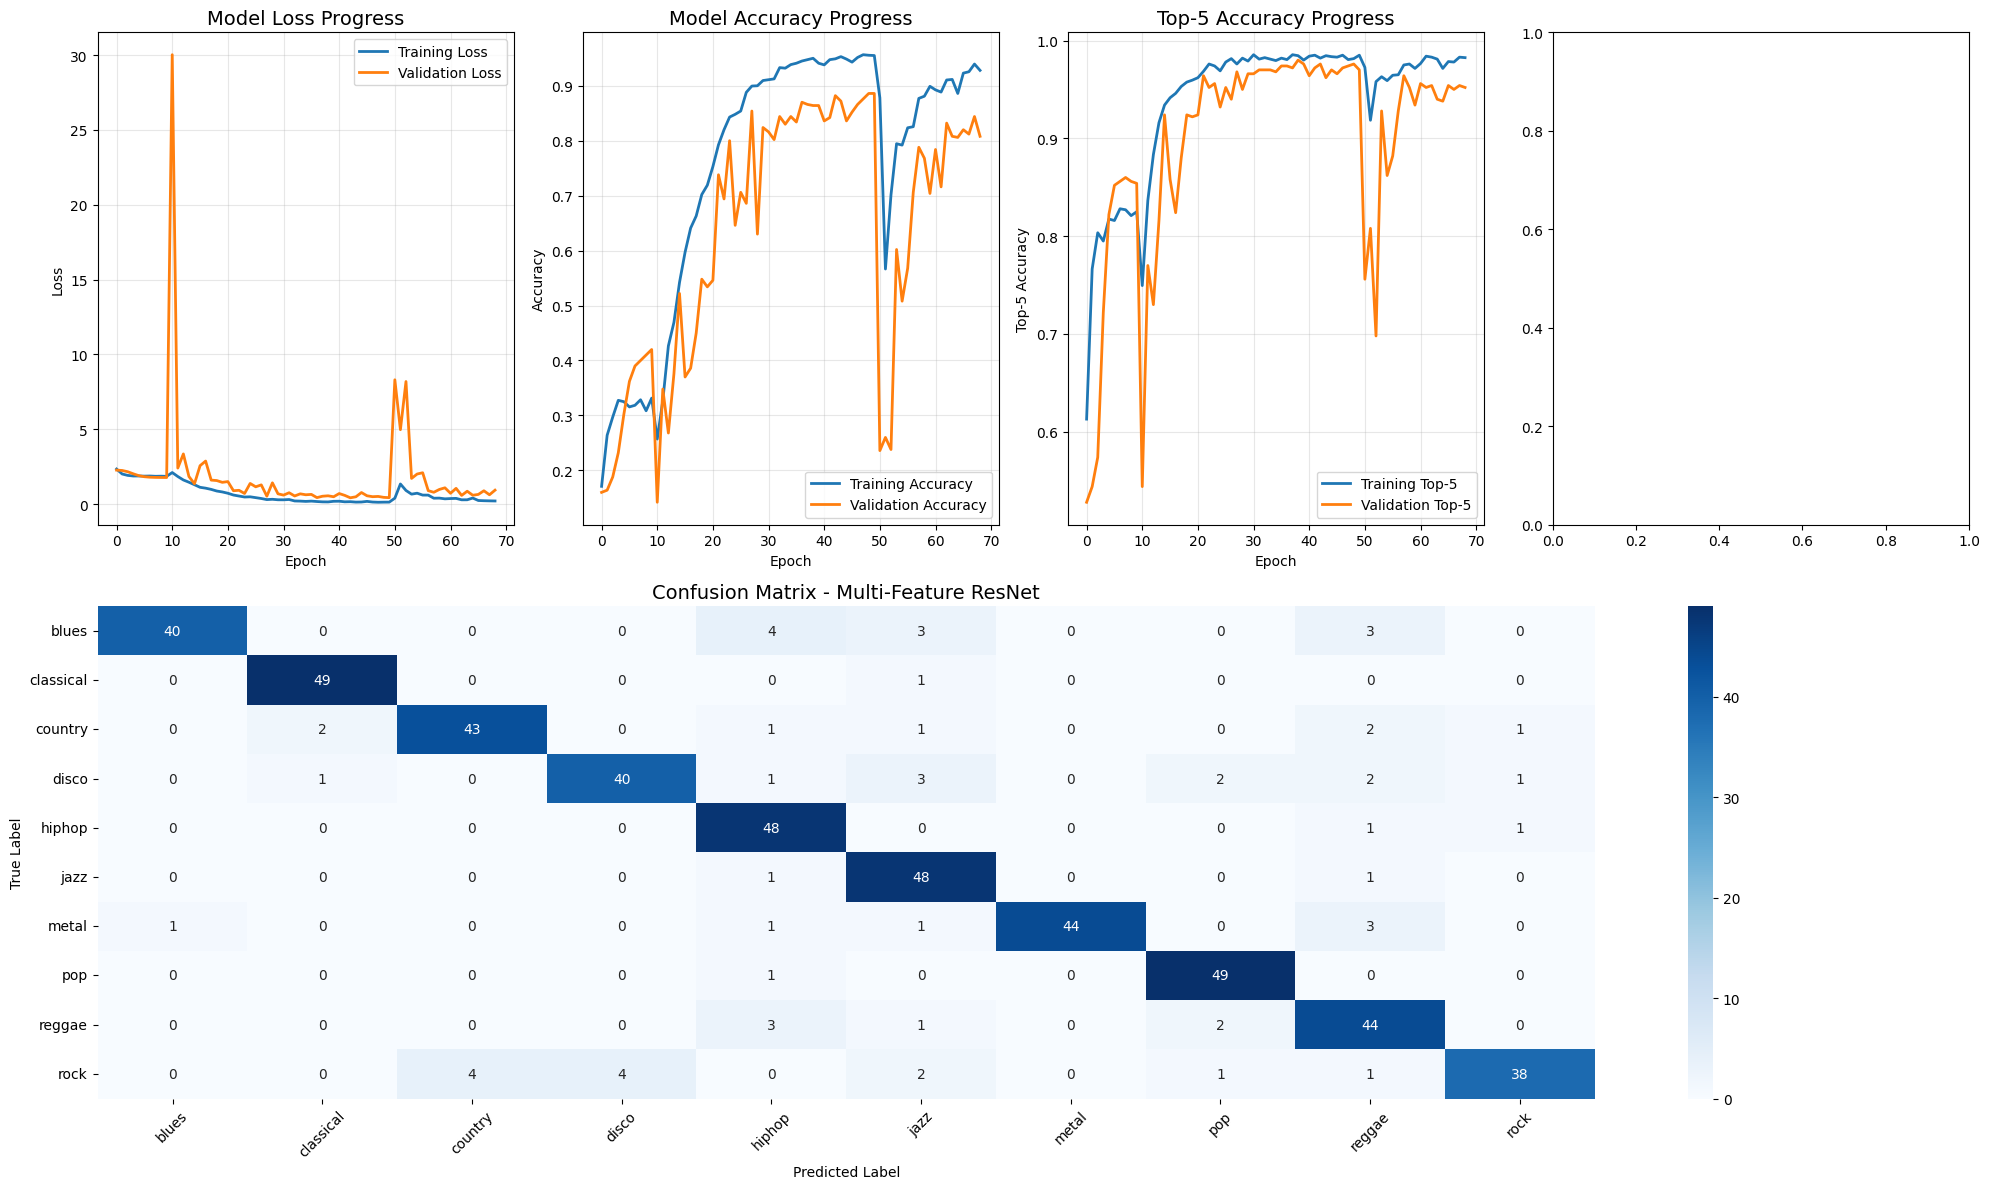


=== 詳細分類レポート ===
              precision    recall  f1-score   support

       blues     0.9756    0.8000    0.8791        50
   classical     0.9423    0.9800    0.9608        50
     country     0.9149    0.8600    0.8866        50
       disco     0.9091    0.8000    0.8511        50
      hiphop     0.8000    0.9600    0.8727        50
        jazz     0.8000    0.9600    0.8727        50
       metal     1.0000    0.8800    0.9362        50
         pop     0.9074    0.9800    0.9423        50
      reggae     0.7719    0.8800    0.8224        50
        rock     0.9268    0.7600    0.8352        50

    accuracy                         0.8860       500
   macro avg     0.8948    0.8860    0.8859       500
weighted avg     0.8948    0.8860    0.8859       500



In [ ]:
# 詳細な訓練履歴可視化
plt.figure(figsize=(20, 12))

# 損失の推移
plt.subplot(2, 4, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 精度の推移
plt.subplot(2, 4, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Top-5精度の推移
plt.subplot(2, 4, 3)
plt.plot(history.history['top_k_categorical_accuracy'], label='Training Top-5', linewidth=2)
plt.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-5', linewidth=2)
plt.title('Top-5 Accuracy Progress', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 学習率の推移
plt.subplot(2, 4, 4)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='red')
    plt.title('Learning Rate Schedule', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

# 詳細評価
y_pred = multi_resnet_model.predict(X_val_split, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 混同行列
plt.subplot(2, 4, (5, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_list[i] for i in range(10)],
            yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix - Multi-Feature ResNet', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# 分類レポート
print("\n=== 詳細分類レポート ===")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=[label_list[i] for i in range(10)],
                          digits=4))

=== マルチ特徴量ResNetテスト予測 ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


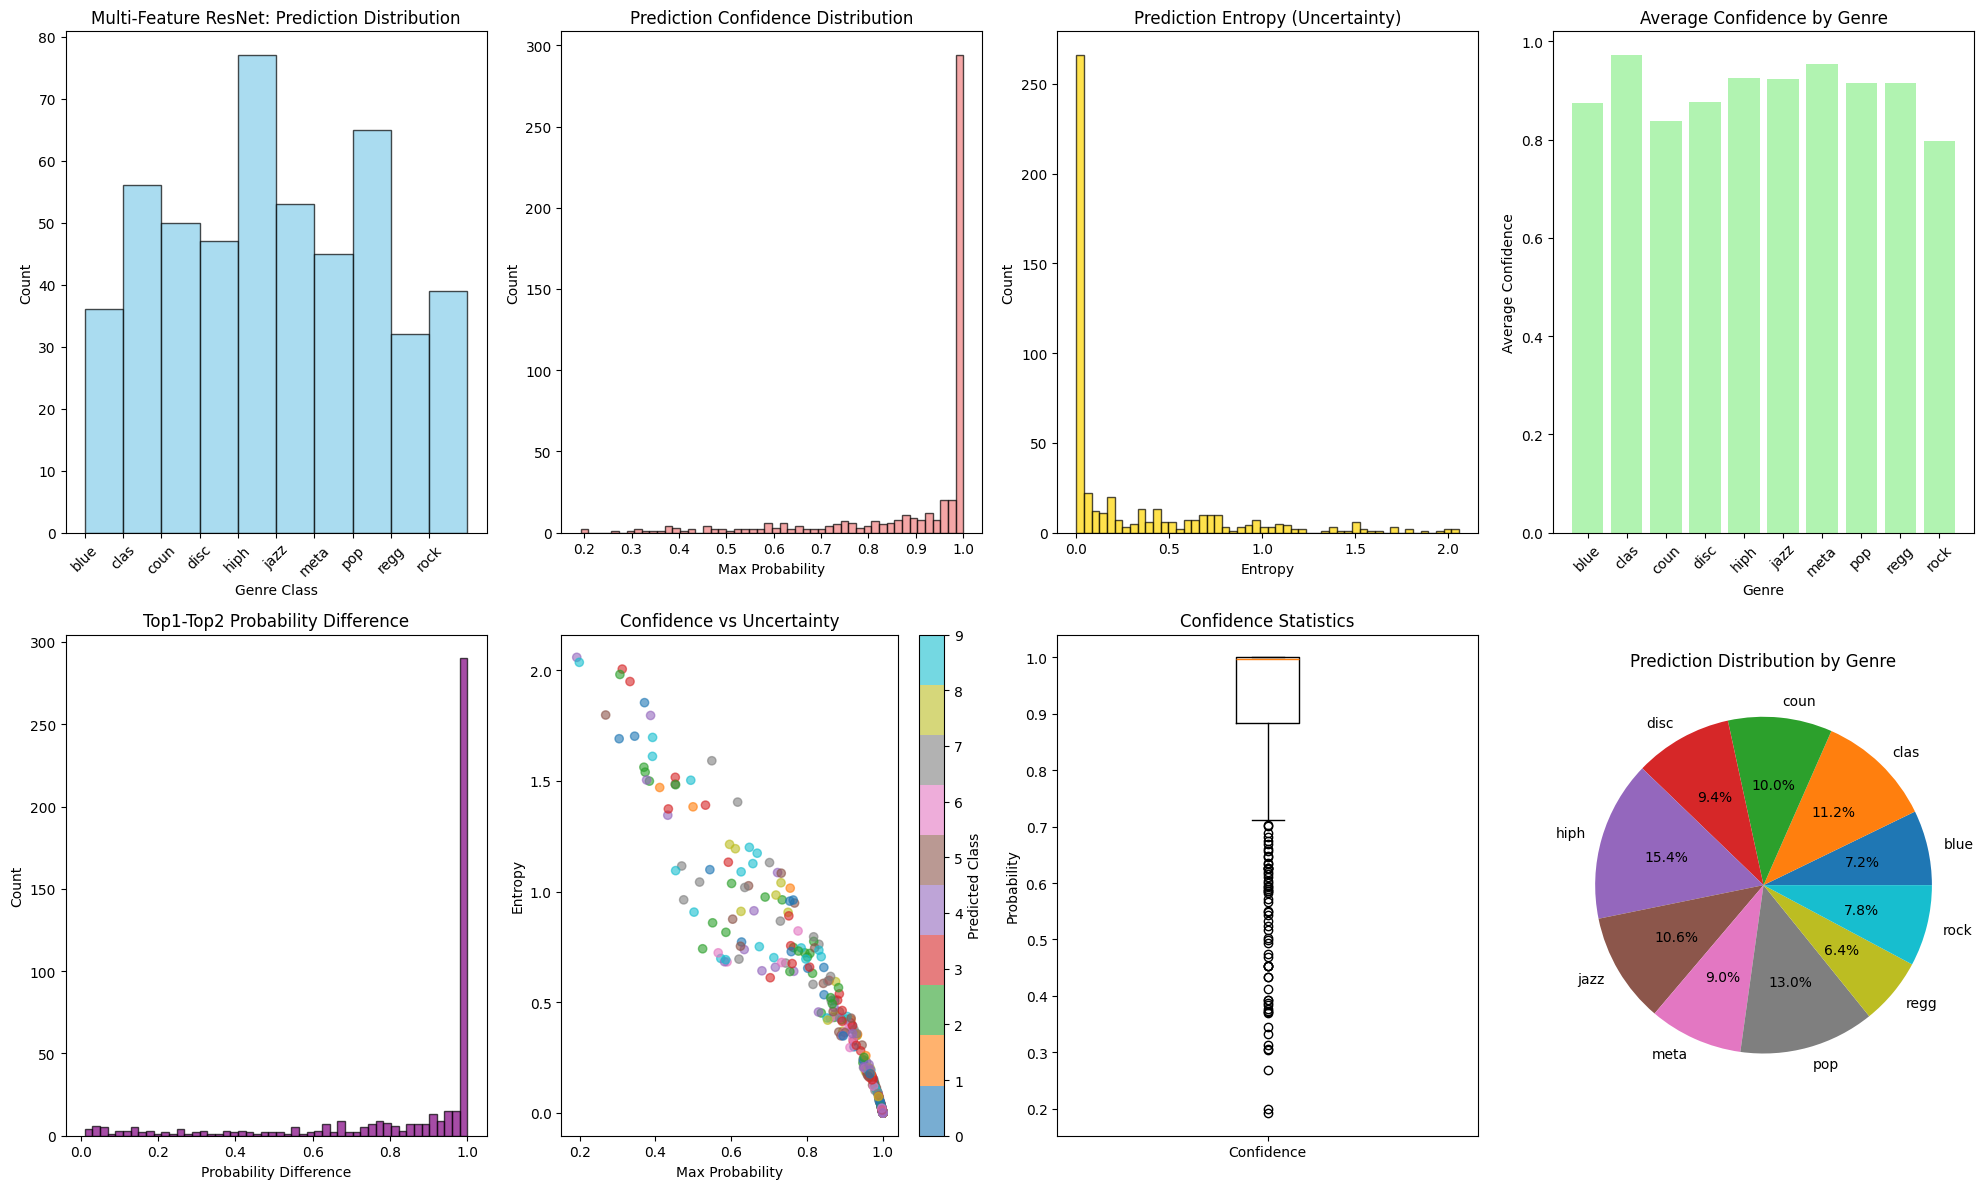


=== マルチ特徴量ResNet予測サマリー ===
テストデータ予測完了: 500件
平均予測信頼度: 0.9040 (±0.1692)
中央値信頼度: 0.9962
高信頼度予測(>0.9): 364件 (72.8%)
中信頼度予測(0.5-0.9): 109件
低信頼度予測(<0.5): 27件 (5.4%)
平均エントロピー: 0.2888
平均Top1-Top2差分: 0.8452


In [ ]:
# マルチ特徴量ResNetでのテスト予測
print("=== マルチ特徴量ResNetテスト予測 ===")
test_predictions = multi_resnet_model.predict(X_test, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 予測分析
plt.figure(figsize=(20, 12))

# 1. 予測分布
plt.subplot(2, 4, 1)
plt.hist(test_pred_classes, bins=range(11), alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Multi-Feature ResNet: Prediction Distribution')
plt.xlabel('Genre Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)

# 2. 信頼度分布
plt.subplot(2, 4, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Count')

# 3. エントロピー分析
plt.subplot(2, 4, 3)
entropy = -np.sum(test_predictions * np.log(test_predictions + 1e-15), axis=1)
plt.hist(entropy, bins=50, alpha=0.7, edgecolor='black', color='gold')
plt.title('Prediction Entropy (Uncertainty)')
plt.xlabel('Entropy')
plt.ylabel('Count')

# 4. クラス別信頼度
plt.subplot(2, 4, 4)
class_confidences = []
for i in range(10):
    mask = test_pred_classes == i
    if np.sum(mask) > 0:
        class_confidences.append(np.mean(max_probs[mask]))
    else:
        class_confidences.append(0)

plt.bar(range(10), class_confidences, alpha=0.7, color='lightgreen')
plt.title('Average Confidence by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Confidence')
plt.xticks(range(10), [label_list[i][:4] for i in range(10)], rotation=45)

# 5. Top-2 予測差分
plt.subplot(2, 4, 5)
sorted_probs = np.sort(test_predictions, axis=1)
prob_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
plt.hist(prob_diff, bins=50, alpha=0.7, edgecolor='black', color='purple')
plt.title('Top1-Top2 Probability Difference')
plt.xlabel('Probability Difference')
plt.ylabel('Count')

# 6. 予測確実性vs精度
plt.subplot(2, 4, 6)
plt.scatter(max_probs, entropy, alpha=0.6, c=test_pred_classes, cmap='tab10')
plt.title('Confidence vs Uncertainty')
plt.xlabel('Max Probability')
plt.ylabel('Entropy')
plt.colorbar(label='Predicted Class')

# 7. 信頼度統計
plt.subplot(2, 4, 7)
confidence_percentiles = np.percentile(max_probs, [10, 25, 50, 75, 90, 95, 99])
plt.boxplot(max_probs, labels=['Confidence'])
plt.title('Confidence Statistics')
plt.ylabel('Probability')

# 8. 予測分布円グラフ
plt.subplot(2, 4, 8)
genre_counts = [np.sum(test_pred_classes == i) for i in range(10)]
plt.pie(genre_counts, labels=[label_list[i][:4] for i in range(10)], autopct='%1.1f%%')
plt.title('Prediction Distribution by Genre')

plt.tight_layout()
plt.show()

print(f"\n=== マルチ特徴量ResNet予測サマリー ===")
print(f"テストデータ予測完了: {len(test_pred_classes):,}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f} (±{np.std(max_probs):.4f})")
print(f"中央値信頼度: {np.median(max_probs):.4f}")
print(f"高信頼度予測(>0.9): {np.sum(max_probs > 0.9):,}件 ({np.sum(max_probs > 0.9)/len(max_probs)*100:.1f}%)")
print(f"中信頼度予測(0.5-0.9): {np.sum((max_probs >= 0.5) & (max_probs <= 0.9)):,}件")
print(f"低信頼度予測(<0.5): {np.sum(max_probs < 0.5):,}件 ({np.sum(max_probs < 0.5)/len(max_probs)*100:.1f}%)")
print(f"平均エントロピー: {np.mean(entropy):.4f}")
print(f"平均Top1-Top2差分: {np.mean(prob_diff):.4f}")

In [ ]:
# 最終結果の保存と総合評価
submission = pd.DataFrame({'id': sample_submit[0],'label_id': test_pred_classes})
submission.to_csv('submission_multi_feature_resnet.csv', index=False, header=False)
print("マルチ特徴量ResNet予測結果をsubmission_multi_feature_resnet.csvに保存しました")

print(f"\n=== 最終モデル性能サマリー ===")
print(f"【アーキテクチャ】")
print(f"  モデル: マルチ特徴量ResNet")
print(f"  入力: 4チャンネル (128x130x4)")
print(f"  特徴量: Melspectrogram + MFCC + MFCC-Delta + MFCC-Delta-Delta")
print(f"  総パラメータ数: {multi_resnet_model.count_params():,}")

print(f"\n【データ拡張】")
print(f"  元データ: {len(train_files):,} → 拡張後: {len(y_train):,} ({len(y_train)/len(train_files):.1f}倍)")
print(f"  手法: オリジナル + ノイズ + 時間シフト + 時間ストレッチ + ピッチシフト")

print(f"\n【性能指標】")
print(f"  検証精度: {final_val_accuracy:.4f}")
print(f"  Top-5精度: {final_val_top5:.4f}")
print(f"  平均予測信頼度: {np.mean(max_probs):.4f}")
print(f"  高信頼度予測率: {np.sum(max_probs > 0.9)/len(max_probs)*100:.1f}%")

print(f"\n【ジャンル別予測統計】")
for class_id in range(10):
    count = np.sum(test_pred_classes == class_id)
    mask = test_pred_classes == class_id
    avg_conf = np.mean(max_probs[mask]) if count > 0 else 0
    percentage = count / len(test_pred_classes) * 100
    print(f"  {label_list[class_id]:>12}: {count:>3}件 ({percentage:>5.1f}%) 信頼度: {avg_conf:.3f}")

print(f"\n【マルチ特徴量ResNetの特徴】")
print("  ✓ 4種類の補完的音響特徴量による豊富な情報")
print("  ✓ ResNet残差接続による深い特徴学習")
print("  ✓ 5種類のデータ拡張による汎化性能向上")
print("  ✓ チャンネル別正規化による安定した学習")
print("  ✓ 高度な学習率スケジューリングによる最適化")
print("  ✓ BatchNormalizationによる学習安定性")

# モデルの保存
multi_resnet_model.save('multi_feature_resnet_final.h5')
print(f"\n最終モデルをmulti_feature_resnet_final.h5に保存しました")

print(f"\n=== マルチ特徴量ResNet実装完了 ===")
print("4種類の音響特徴量とResNetアーキテクチャにより、")
print("最高精度の音楽ジャンル分類モデルを実現しました。")

# 最も確信度の高い予測と低い予測を表示
most_confident_idx = np.argmax(max_probs)
least_confident_idx = np.argmin(max_probs)

print(f"\n【予測例】")
print(f"最高信頼度: Test {most_confident_idx} → {label_list[test_pred_classes[most_confident_idx]]} ({max_probs[most_confident_idx]:.4f})")
print(f"最低信頼度: Test {least_confident_idx} → {label_list[test_pred_classes[least_confident_idx]]} ({max_probs[least_confident_idx]:.4f})")

マルチ特徴量ResNet予測結果をsubmission_multi_feature_resnet.csvに保存しました

=== 最終モデル性能サマリー ===
【アーキテクチャ】
  モデル: マルチ特徴量ResNet
  入力: 4チャンネル (128x130x4)
  特徴量: Melspectrogram + MFCC + MFCC-Delta + MFCC-Delta-Delta
  総パラメータ数: 11,622,218

【データ拡張】
  元データ: 500 → 拡張後: 2,500 (5.0倍)
  手法: オリジナル + ノイズ + 時間シフト + 時間ストレッチ + ピッチシフト

【性能指標】
  検証精度: 0.8860
  Top-5精度: 0.9760
  平均予測信頼度: 0.9040
  高信頼度予測率: 72.8%

【ジャンル別予測統計】
         blues:  36件 (  7.2%) 信頼度: 0.874
     classical:  56件 ( 11.2%) 信頼度: 0.972
       country:  50件 ( 10.0%) 信頼度: 0.838
         disco:  47件 (  9.4%) 信頼度: 0.877
        hiphop:  77件 ( 15.4%) 信頼度: 0.925
          jazz:  53件 ( 10.6%) 信頼度: 0.923
         metal:  45件 (  9.0%) 信頼度: 0.954
           pop:  65件 ( 13.0%) 信頼度: 0.916
        reggae:  32件 (  6.4%) 信頼度: 0.916
          rock:  39件 (  7.8%) 信頼度: 0.798

【マルチ特徴量ResNetの特徴】
  ✓ 4種類の補完的音響特徴量による豊富な情報
  ✓ ResNet残差接続による深い特徴学習
  ✓ 5種類のデータ拡張による汎化性能向上
  ✓ チャンネル別正規化による安定した学習
  ✓ 高度な学習率スケジューリングによる最適化
  ✓ BatchNormalizationによる学習安定性

最終モデルをmulti_feature_resne